In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-11-09 15:30:17.619910: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-09 15:30:17.639179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731166217.657268   39418 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731166217.662560   39418 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 15:30:17.680862: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Path to the data folder containing label CSV files
DATA_PATH = "data"
labels = ["hello", "thanks", "yes", "no", "iloveyou"]

In [3]:
# Load data
data = []
targets = []

# Iterate through the labels and load the corresponding data
for label in labels:
    file_path = os.path.join(DATA_PATH, f"{label}_keypoints.csv")
    if not os.path.exists(file_path):
        print(f"Warning: Keypoints file for '{label}' not found at {file_path}")
        continue
    
    df = pd.read_csv(file_path)
    keypoints = df.iloc[:, 1:].values  # Exclude the image_name column if present
    num_samples = len(keypoints)
    
    # Add the keypoints and repeat the label for each sample
    data.append(keypoints)
    targets += [label] * num_samples

In [4]:
# Convert the data into a single array and flatten it for LSTM
X = np.concatenate(data, axis=0)  # Concatenate all keypoints data into a single array
y = np.array(targets)

In [5]:
# Print shapes to debug
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (11243, 63)
y shape: (11243,)


In [6]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [7]:
# Print the actual label order
print("Actual Label Order:")
print(label_encoder.classes_)

Actual Label Order:
['hello' 'iloveyou' 'no' 'thanks' 'yes']


In [8]:
# Ensure shapes match
print("Encoded labels:", y_encoded.shape)

Encoded labels: (11243,)


In [9]:
# Pad the sequences (if necessary)
max_length = X.shape[1]  # Assuming the sequences have already been standardized
X = pad_sequences(X, maxlen=max_length, dtype='float32', padding='post', truncating='post')

In [10]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [11]:
# Reshape X for LSTM: (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # One feature per timestep
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [12]:
# Check reshaped X
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

X_train shape: (8994, 63, 1)
X_val shape: (2249, 63, 1)


In [13]:
# Define the improved LSTM model with Bidirectional LSTM layers
num_classes = len(np.unique(y_encoded))
model = tf.keras.models.Sequential([
    # Bidirectional LSTM layer with 64 units
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),  # Dropout to reduce overfitting
    
    # Another Bidirectional LSTM layer with 32 units
    Bidirectional(LSTM(32)),
    Dropout(0.3),  # Dropout to reduce overfitting
    
    # Dense layer for more representation power
    Dense(64, activation="relu"),
    Dropout(0.3),  # Dropout to reduce overfitting
    
    # Output layer with softmax activation for classification
    Dense(num_classes, activation="softmax")
])

I0000 00:00:1731166222.276756   39418 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/sharma/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [15]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 63, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,493 (310.52 KB)

 Trainable params: 79,493 (310.52 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/30


I0000 00:00:1731166226.378621   39519 cuda_dnn.cc:529] Loaded cuDNN version 90300


282/282 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.3590 - loss: 1.5312 - val_accuracy: 0.4860 - val_loss: 1.3089
Epoch 2/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.4960 - loss: 1.2105 - val_accuracy: 0.6959 - val_loss: 0.7710
Epoch 3/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.7161 - loss: 0.7220 - val_accuracy: 0.8253 - val_loss: 0.4341
Epoch 4/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.7814 - loss: 0.5600 - val_accuracy: 0.8675 - val_loss: 0.3692
Epoch 5/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8323 - loss: 0.4433 - val_accuracy: 0.9071 - val_loss: 0.2757
Epoch 6/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.8689 - loss: 0.3781 - val_accuracy: 0.9213 - val_loss: 0.2418
Epoch 7/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8869 - loss: 0.3289 - val_accuracy: 0.9155 - val_loss: 0.2576
Epoch 8/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.8995 - loss: 0.2965 - val_accurac

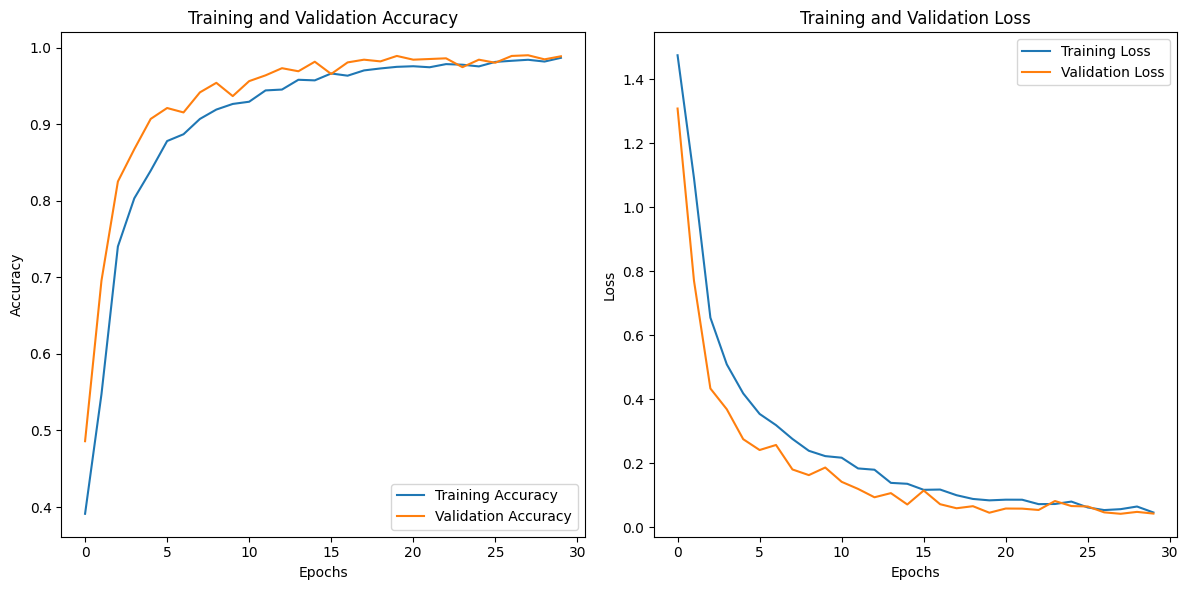

In [17]:
# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Model evaluation
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [19]:
# Generate Classification Report
print("Classification Report:\n")
print(classification_report(y_val, y_val_pred_classes, target_names=label_encoder.classes_))

Classification Report:

              precision    recall  f1-score   support

       hello       1.00      0.97      0.98       386
    iloveyou       1.00      0.98      0.99       361
          no       0.96      0.98      0.97       365
      thanks       0.99      1.00      1.00       809
         yes       0.99      1.00      0.99       328

    accuracy                           0.99      2249
   macro avg       0.99      0.99      0.99      2249
weighted avg       0.99      0.99      0.99      2249



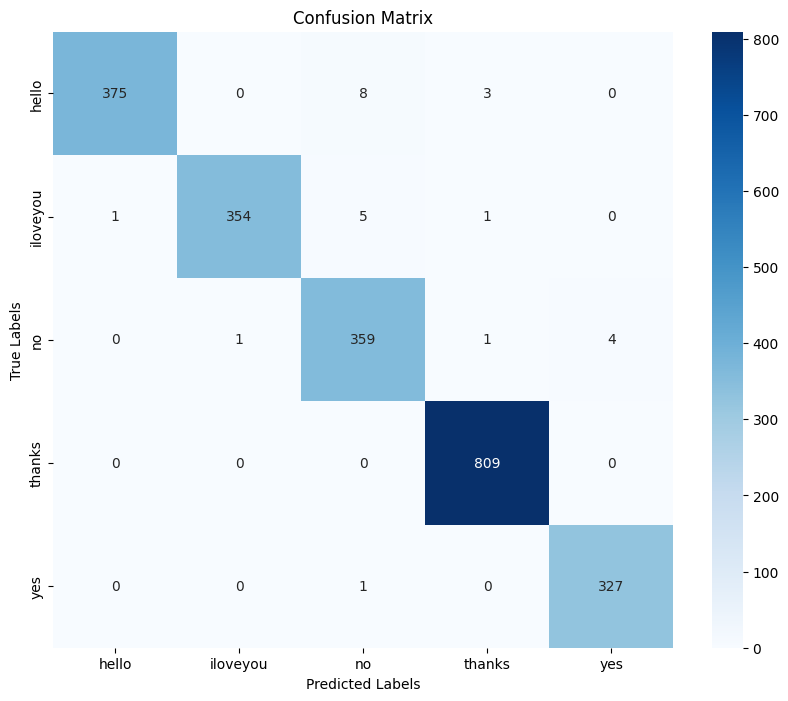

In [20]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [22]:
# Save the trained model
model.save("sign_language_model.keras")